## Extract  data without exploration

In [1]:
import covidcast
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
from threading import Thread

Covidcast logs warning at every missing data

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Pull data

In [3]:
start_date = date(2020, 1, 1)
end_date = date(2021, 11, 11)
states = ['NY', 'MI', 'MN']

In [4]:
signals = pd.read_csv('signal_name_with_redundant_data.csv')
signals = signals[['indicatorDataSource','indicatorId']]

In [5]:
signals = signals.drop_duplicates()

In [7]:
signals

indicatorDataSource                                       indicatorId
0             safegraph                                   bars_visit_prop
1             safegraph                            restaurants_visit_prop
2             fb-survey                         smoothed_wwearing_mask_7d
3             fb-survey                    smoothed_wothers_masked_public
4             fb-survey  smoothed_wcovid_vaccinated_appointment_or_accept
5             fb-survey                        smoothed_wcovid_vaccinated
6       google-symptoms               sum_anosmia_ageusia_smoothed_search
7         doctor-visits                                  smoothed_adj_cli
8             fb-survey                                     smoothed_wcli
9             fb-survey                            smoothed_whh_cmnty_cli
10               quidel                    covid_ag_smoothed_pct_positive
11  hospital-admissions                  smoothed_adj_covid19_from_claims
12             jhu-csse                     confirmed_7dav_incidence_prop
13             jhu-csse                        deaths_7dav_incidence_prop

In [6]:
dfCollector = []

In [26]:
threads = [None] * signals.shape[0]

In [27]:
def get_signal(dataSource, signalName, results):
    results.append(covidcast.signal(dataSource, signalName,
                        start_date, end_date,
                        "state", states))

In [28]:
for i in range(len(threads)):
    dataSource = signals.iloc[i].indicatorDataSource
    signalname = signals.iloc[i].indicatorId
    threads[i] = Thread(target=get_signal, args=(dataSource, signalname, dfCollector))
    threads[i].start()

In [29]:
for i in range(len(threads)):
    threads[i].join()

## Process Data

In [53]:
merged_dfs = pd.DataFrame()
timediff_in_days = (end_date - start_date).days + 1
state = dfCollector[0].geo_value.unique()[2]
timediff_in_days

681

In [54]:
merged_dfs['time_value'] = pd.date_range(start_date, periods=timediff_in_days, freq="d")

In [55]:
for df in dfCollector:
    selected_cols = df[df.geo_value == state][['time_value', 'value']]
    col_name = df.iloc[0].data_source +'_'+df.iloc[0].signal
     
    selected_cols.columns = ['time_value', col_name]

    merged_dfs = pd.merge(merged_dfs,selected_cols,on='time_value',how='left')

In [56]:
merged_dfs = merged_dfs.set_index('time_value')

In [57]:
merged_dfs.to_csv(f'data/raw_data_{state}.csv')

In [136]:
normalized_df=(merged_dfs-merged_dfs.min())/(merged_dfs.max()-merged_dfs.min())
normalized_df.index = merged_dfs.index

In [137]:
normalized_df['jhu-csse_confirmed_7dav_incidence_prop'].isna().sum()

57

<AxesSubplot:xlabel='time_value'>

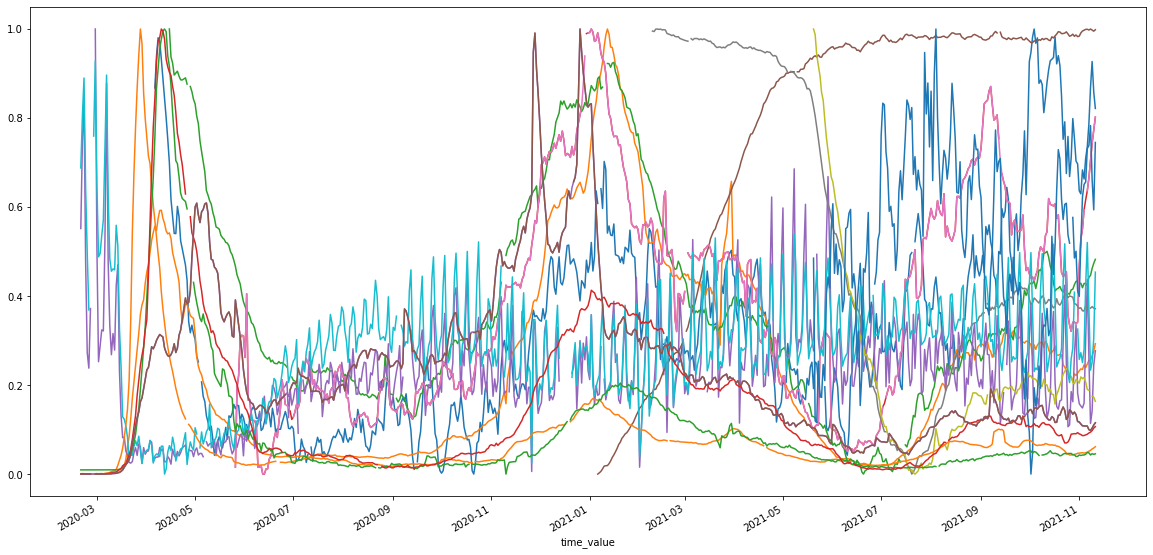

In [138]:
normalized_df = normalized_df.dropna(subset=['jhu-csse_confirmed_7dav_incidence_prop'])
normalized_df.plot(legend=False, figsize=(20,10))

In [4]:
normalized_df.to_csv(f'data/normalized_data_{state}.csv')

NameError: name 'normalized_df' is not defined

In [143]:
normalized_smoothed = pd.DataFrame()

In [144]:
for col in normalized_df.columns:
    normalized_smoothed[col] = normalized_df[col].rolling(7,7,win_type='gaussian').sum(std=5)

<AxesSubplot:xlabel='time_value'>

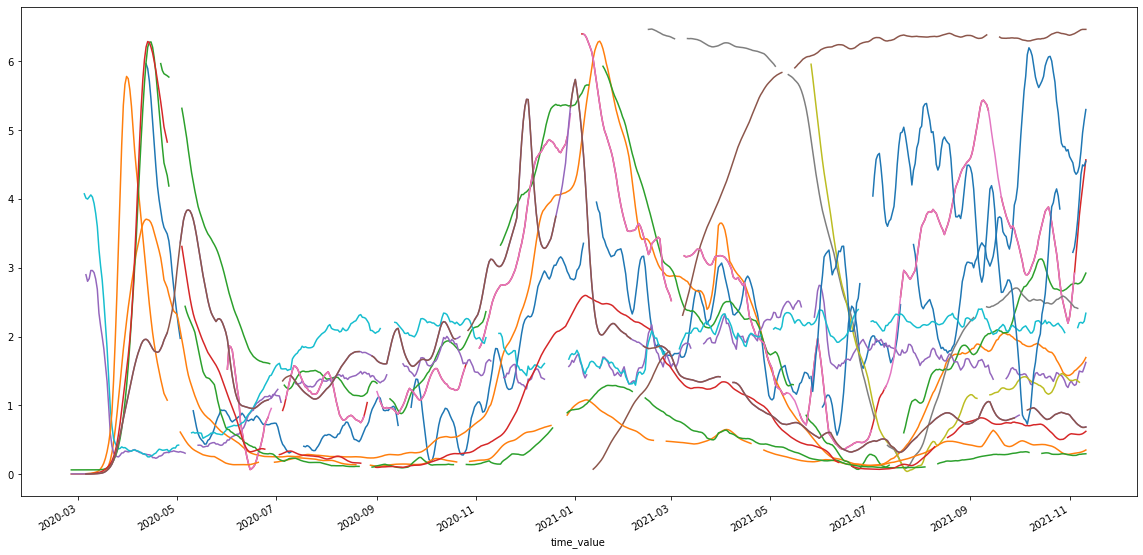

In [146]:
normalized_smoothed.plot(legend=False, figsize=(20,10))

In [3]:
ads = pd.read_csv(f'data/raw_data_mi.csv')

In [13]:
val = ads['fb-survey_smoothed_wcli'][600:650].copy()

In [30]:
test = ads['fb-survey_smoothed_wcli'][600:650].copy()

In [73]:
test.loc[610:615] = np.nan

In [5]:
σ = 1
def custom_fill_na(selected):
    for index, num in selected.items():
        if np.isnan(num) and index > 4 and index < selected.index.max() - 3:

            nans = 0
            for i in range(index, selected.index.max()-3):
                if np.isnan(selected.loc[i]):
                    nans += 1
                else:
                    break

            last_known_ind = index - 1
            first_known_ind = index + nans
            sdiff = 3
            
            indexes = np.arange(index - sdiff,index+nans+sdiff)
            
            diff_m_43 = selected.loc[last_known_ind - 2] - selected.loc[last_known_ind - 3]
            diff_m_32 = selected.loc[last_known_ind - 1] - selected.loc[last_known_ind - 2]
            diff_m_21 = selected.loc[last_known_ind] - selected.loc[last_known_ind - 1]

            diff_m_12 = selected.loc[first_known_ind]    - selected.loc[first_known_ind + 1]
            diff_m_23 = selected.loc[first_known_ind + 1]- selected.loc[first_known_ind + 2]
            diff_m_34 = selected.loc[first_known_ind + 2]- selected.loc[first_known_ind + 3]
            

            diffs = np.concatenate((
                [diff_m_43, diff_m_32, diff_m_21],
                np.linspace(diff_m_21, diff_m_12, num=nans),
                [diff_m_12, diff_m_23, diff_m_34]             
                                   ))
            
            lindiff = (selected.loc[first_known_ind] - selected.loc[last_known_ind]) / nans 

            itnum = 0
            for i in range(index, index + nans):
                itnum += 1
                base = selected.loc[last_known_ind] + itnum * lindiff
                deviation = sum( np.exp( -(indexes - i)**2 / (2 * σ**2) ) * diffs )

                replace_value = base + deviation
                selected.loc[i] = replace_value
            

1.32596495 -0.23833972465889341
1.3598733 -0.25645674101738114
1.39378165 -0.2530895818724587
1.42769 -0.24763735192084646
1.46159835 -0.2416168989241515
1.4955067 -0.2281024401722438


<AxesSubplot:>

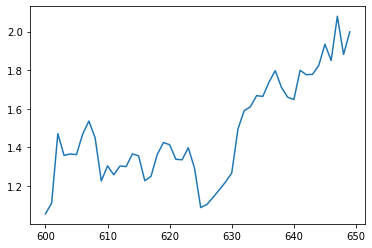

In [80]:
test = ads['fb-survey_smoothed_wcli'][600:650].copy()
val = ads['fb-survey_smoothed_wcli'][600:650].copy()
test.loc[625:630] = np.nan
backv = test.copy()
custom_fill_na(test)
test.plot()

<AxesSubplot:>

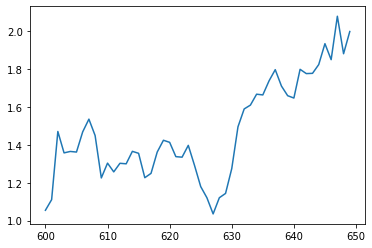

In [81]:
val.plot()

<AxesSubplot:>

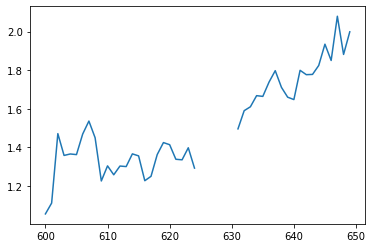

In [119]:
backv.plot()

In [4]:
merged_dfs = ads.set_index('time_value')

<AxesSubplot:xlabel='time_value'>

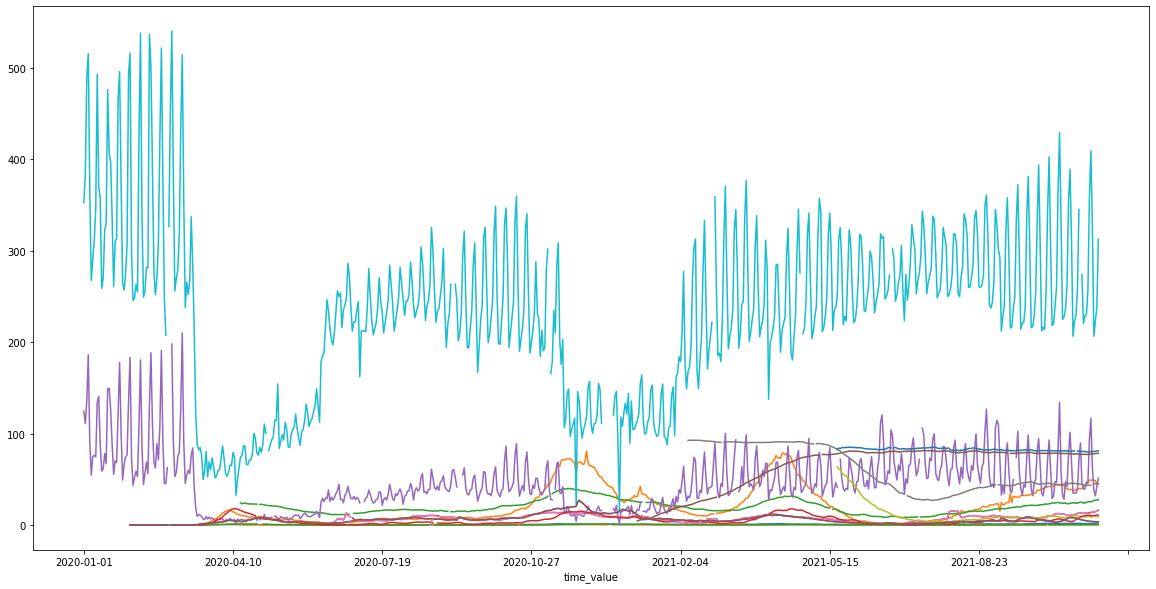

In [5]:
merged_dfs.plot(legend=False, figsize=(20,10))

In [6]:
normalized_df=(merged_dfs-merged_dfs.min())/(merged_dfs.max()-merged_dfs.min())
normalized_df.index = merged_dfs.index

<AxesSubplot:xlabel='time_value'>

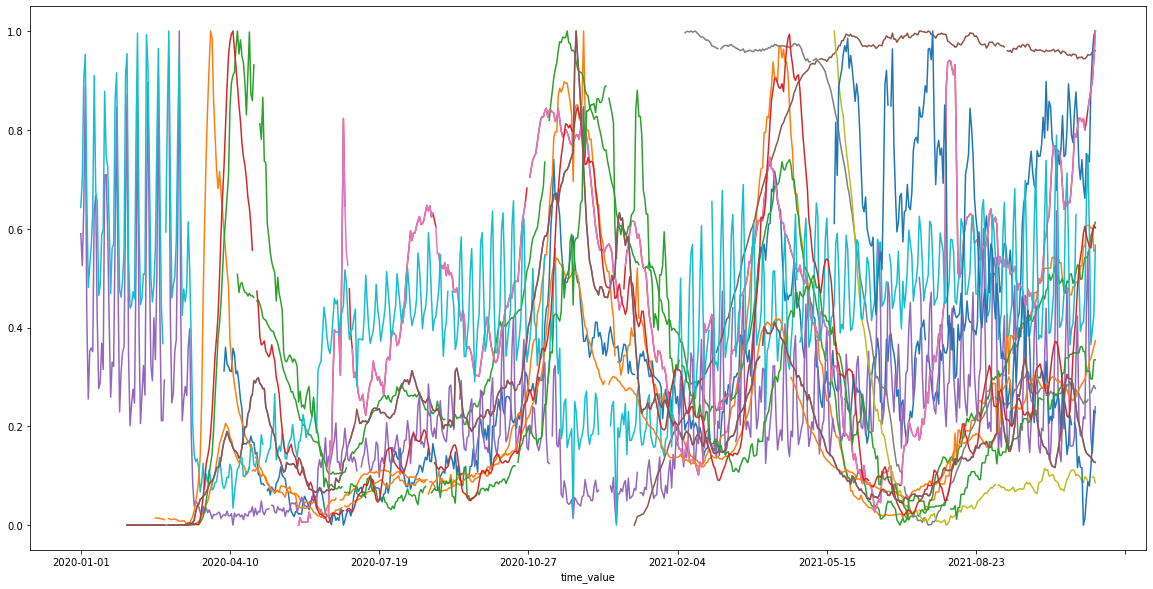

In [7]:
normalized_df.plot(legend=False, figsize=(20,10))

<AxesSubplot:xlabel='time_value'>

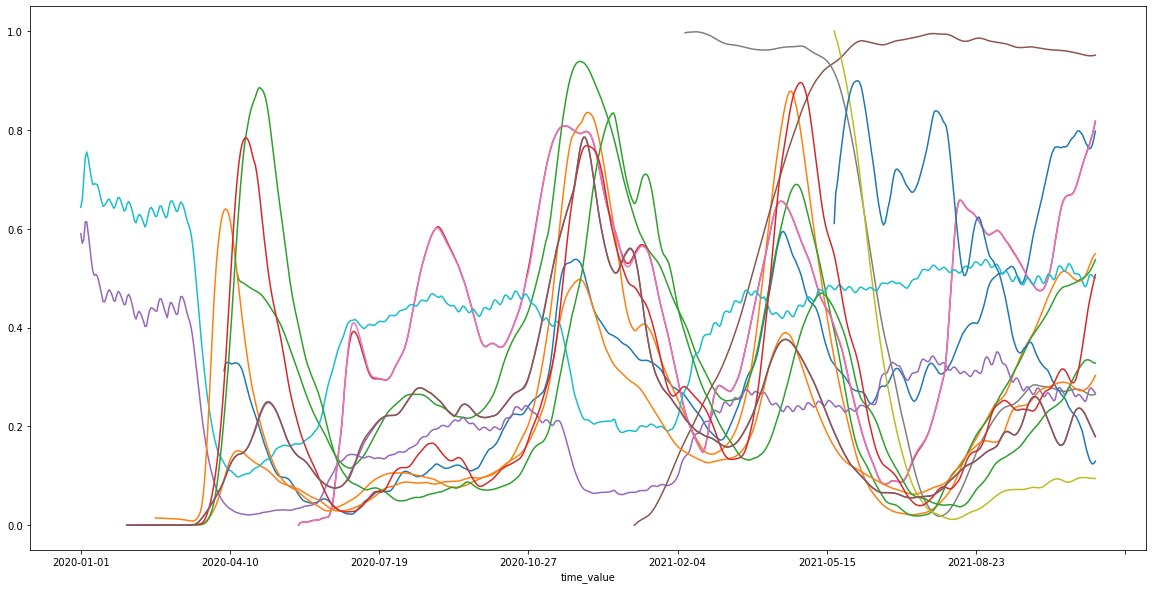

In [12]:
normalized_df.ewm(span=10).mean().ewm(span=10).mean().plot(legend=False, figsize=(20,10))

In [80]:
normalized_smoothed = pd.DataFrame()
for col in normalized_df.columns:
    normalized_smoothed[col] = normalized_df[col].rolling(7,min_periods=7,win_type='gaussian').sum(std=2)

<AxesSubplot:xlabel='time_value'>

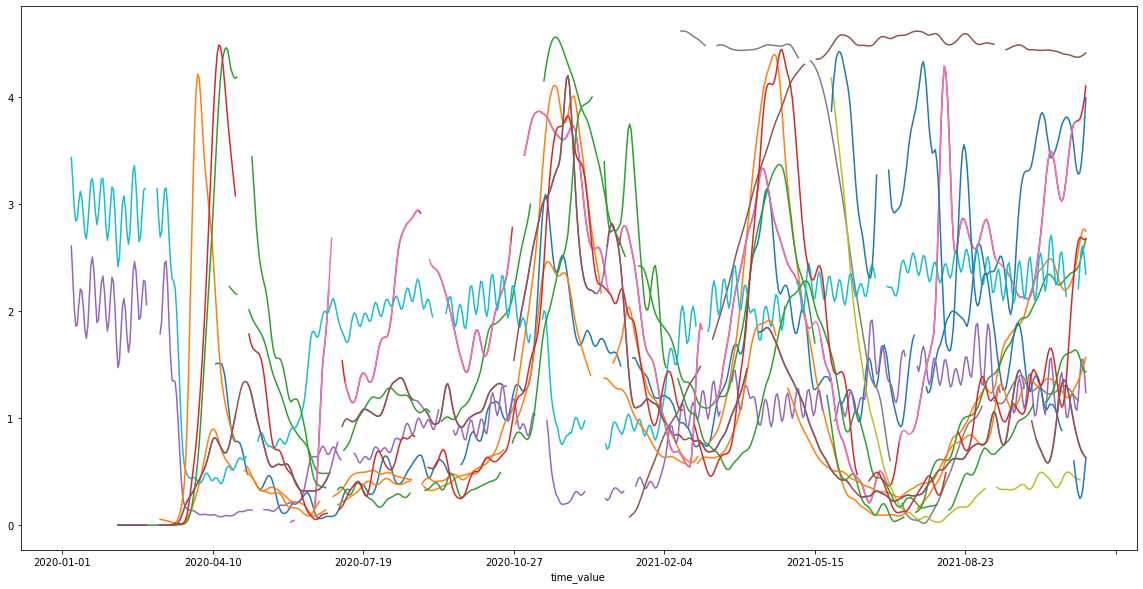

In [81]:
normalized_smoothed.plot(legend=False, figsize=(20,10))

In [82]:
normalized_smoothed = normalized_smoothed.reset_index()
for col in normalized_smoothed:
    if col != 'time_value':
        custom_fill_na(normalized_smoothed[col])

In [83]:
normalized_smoothed = normalized_smoothed.set_index('time_value')

In [108]:
for col in normalized_smoothed.columns:
    normalized_smoothed[col] = normalized_smoothed[col].rolling(7,min_periods=0,win_type='gaussian').sum(std=4)

<AxesSubplot:xlabel='time_value'>

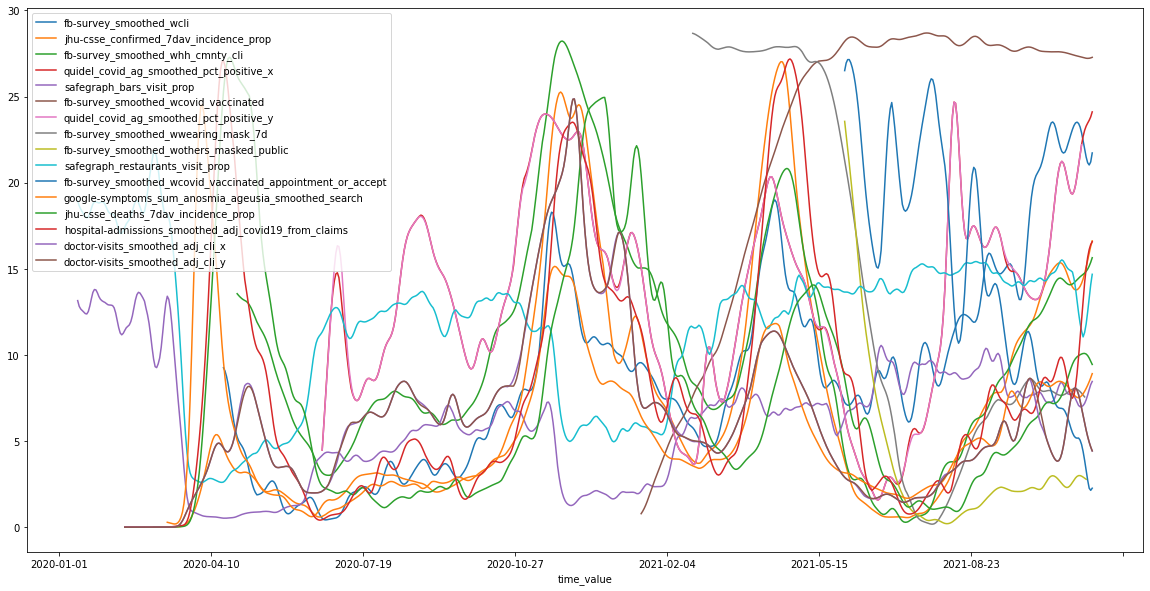

In [109]:
normalized_smoothed.plot(figsize=(20,10))

In [174]:
raw_mi = pd.read_csv(f'data/raw_data_mi.csv')
raw_mn = pd.read_csv(f'data/raw_data_mn.csv')
raw_ny = pd.read_csv(f'data/raw_data_ny.csv')

<AxesSubplot:>

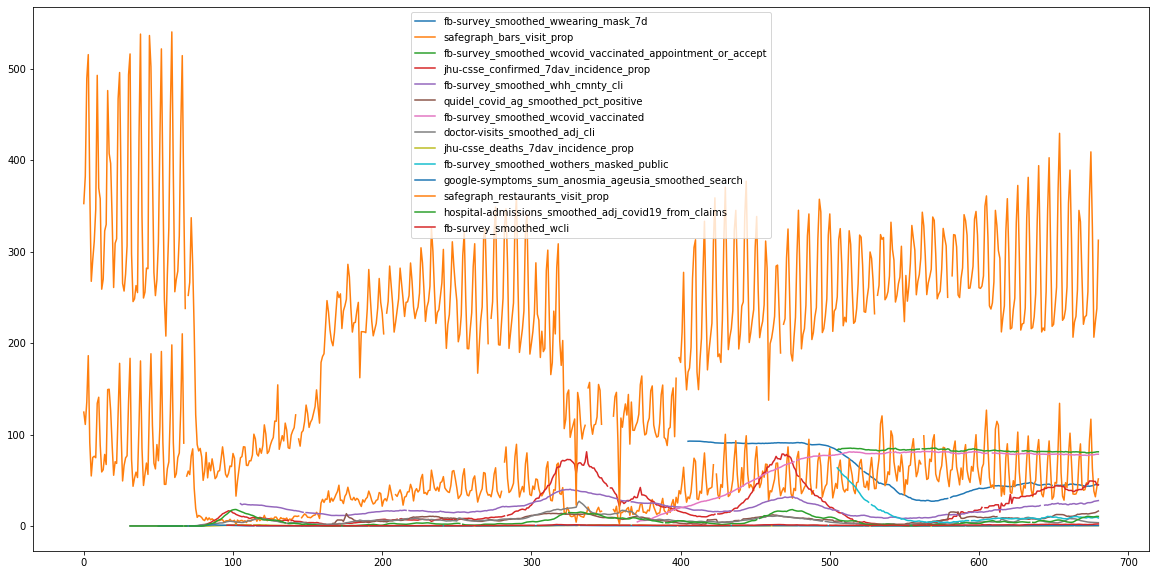

In [175]:
raw_mi.plot(figsize=(20,10))

In [176]:
raw_mi = raw_mi.reset_index()
raw_mn = raw_mn.reset_index()
raw_ny = raw_ny.reset_index()

In [177]:
def calc_infectable(row, df):
    return df[(df['index'] > row['index'] - 120) & (df['index'] <= row['index'])]['jhu-csse_confirmed_7dav_incidence_prop'].sum()

In [178]:
raw_mi['immune'] = raw_mi.apply(lambda x: calc_infectable(x, raw_mi), axis=1)
raw_mn['immune'] = raw_mn.apply(lambda x: calc_infectable(x, raw_mn), axis=1)
raw_ny['immune'] = raw_ny.apply(lambda x: calc_infectable(x, raw_ny), axis=1)

In [180]:
del raw_mi['index']
del raw_mn['index']
del raw_ny['index']

In [181]:
raw_mi = raw_mi.set_index('time_value')
raw_mn = raw_mn.set_index('time_value')
raw_ny = raw_ny.set_index('time_value')

In [182]:
rate_mi = pd.DataFrame(raw_mi.max()-raw_mi.min()).T
rate_mn = pd.DataFrame(raw_mn.max()-raw_mn.min()).T
rate_ny = pd.DataFrame(raw_ny.max()-raw_ny.min()).T

In [183]:
mins_mi = pd.DataFrame(raw_mi.min()).T
mins_mn = pd.DataFrame(raw_mn.min()).T
mins_ny = pd.DataFrame(raw_ny.min()).T

In [184]:
rate_mi.to_csv('data/rate_mi.csv', index = False)
rate_mn.to_csv('data/rate_mn.csv', index = False)
rate_ny.to_csv('data/rate_ny.csv', index = False)
mins_mi.to_csv('data/mins_mi.csv', index = False)
mins_mn.to_csv('data/mins_mn.csv', index = False)
mins_ny.to_csv('data/mins_ny.csv', index = False)

In [9]:
norm_mi = (raw_mi-raw_mi.min())/(raw_mi.max()-raw_mi.min())
norm_mn = (raw_mn-raw_mn.min())/(raw_mn.max()-raw_mn.min())
norm_ny = (raw_ny-raw_ny.min())/(raw_ny.max()-raw_ny.min())

In [13]:
norm_mi * (raw_mi.max()-raw_mi.min()) + raw_mi.min()

fb-survey_smoothed_wwearing_mask_7d  safegraph_bars_visit_prop  \
time_value                                                                   
2020-01-01                                  NaN                 124.649873   
2020-01-02                                  NaN                 111.149413   
2020-01-03                                  NaN                 135.659956   
2020-01-04                                  NaN                 186.384983   
2020-01-05                                  NaN                  91.226405   
...                                         ...                        ...   
2021-11-07                            44.171799                  63.166925   
2021-11-08                            44.816372                  38.340855   
2021-11-09                            45.330494                  32.024162   
2021-11-10                            45.785677                  42.747849   
2021-11-11                            45.387425                  51.561839   

            fb-survey_smoothed_wcovid_vaccinated_appointment_or_accept  \
time_value                                                               
2020-01-01                                                NaN            
2020-01-02                                                NaN            
2020-01-03                                                NaN            
2020-01-04                                                NaN            
2020-01-05                                                NaN            
...                                                       ...            
2021-11-07                                          80.444688            
2021-11-08                                          80.645799            
2021-11-09                                          80.909044            
2021-11-10                                          81.258303            
2021-11-11                                          81.237708            

            jhu-csse_confirmed_7dav_incidence_prop  \
time_value                                           
2020-01-01                                     NaN   
2020-01-02                                     NaN   
2020-01-03                                     NaN   
2020-01-04                                     NaN   
2020-01-05                                     NaN   
...                                            ...   
2021-11-07                               49.320667   
2021-11-08                               48.853390   
2021-11-09                               48.853390   
2021-11-10                               45.069306   
2021-11-11                               45.069306   

            fb-survey_smoothed_whh_cmnty_cli  \
time_value                                     
2020-01-01                               NaN   
2020-01-02                               NaN   
2020-01-03                               NaN   
2020-01-04                               NaN   
2020-01-05                               NaN   
...                                      ...   
2021-11-07                         26.179635   
2021-11-08                         27.006402   
2021-11-09                         27.275295   
2021-11-10                         27.585108   
2021-11-11                         27.896380   

            quidel_covid_ag_smoothed_pct_positive  \
time_value                                          
2020-01-01                                    NaN   
2020-01-02                                    NaN   
2020-01-03                                    NaN   
2020-01-04                                    NaN   
2020-01-05                                    NaN   
...                                           ...   
2021-11-07                              14.196429   
2021-11-08                              14.517857   
2021-11-09                              14.773532   
2021-11-10                              15.634164   
2021-11-11                              16.495861   

            fb-s

In [76]:
adsmi = norm_mi.ewm(span=10).mean().ewm(span=10).mean()
adsmn = norm_mn.ewm(span=10).mean().ewm(span=10).mean()
adsny = norm_ny.ewm(span=10).mean().ewm(span=10).mean()

<AxesSubplot:xlabel='time_value'>

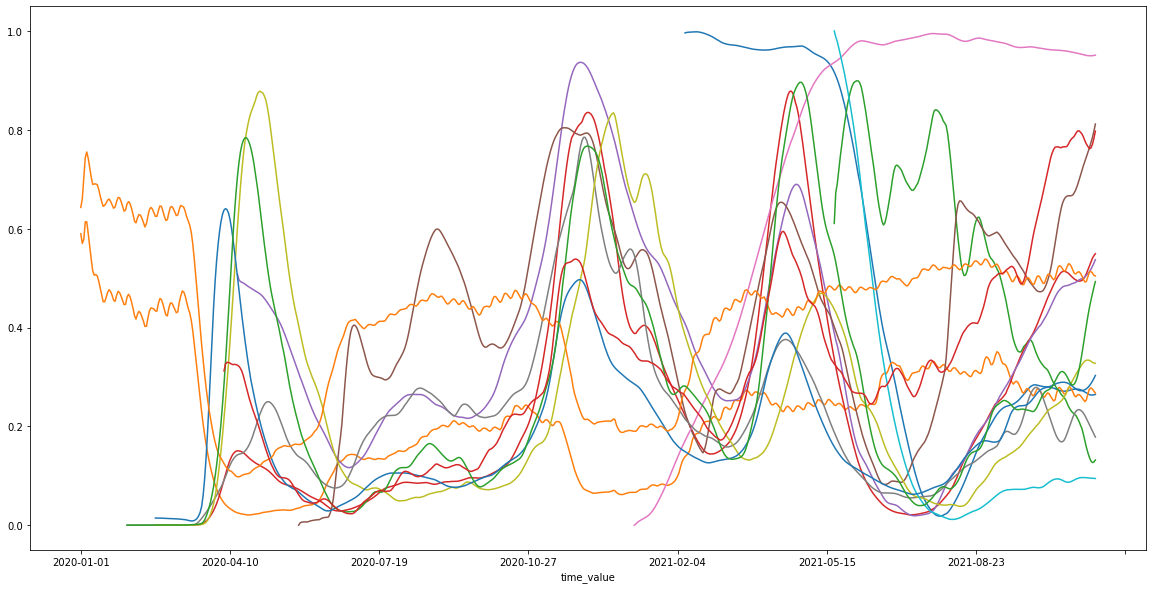

In [73]:
adsmi.plot(legend=False, figsize=(20,10))

<AxesSubplot:xlabel='time_value'>

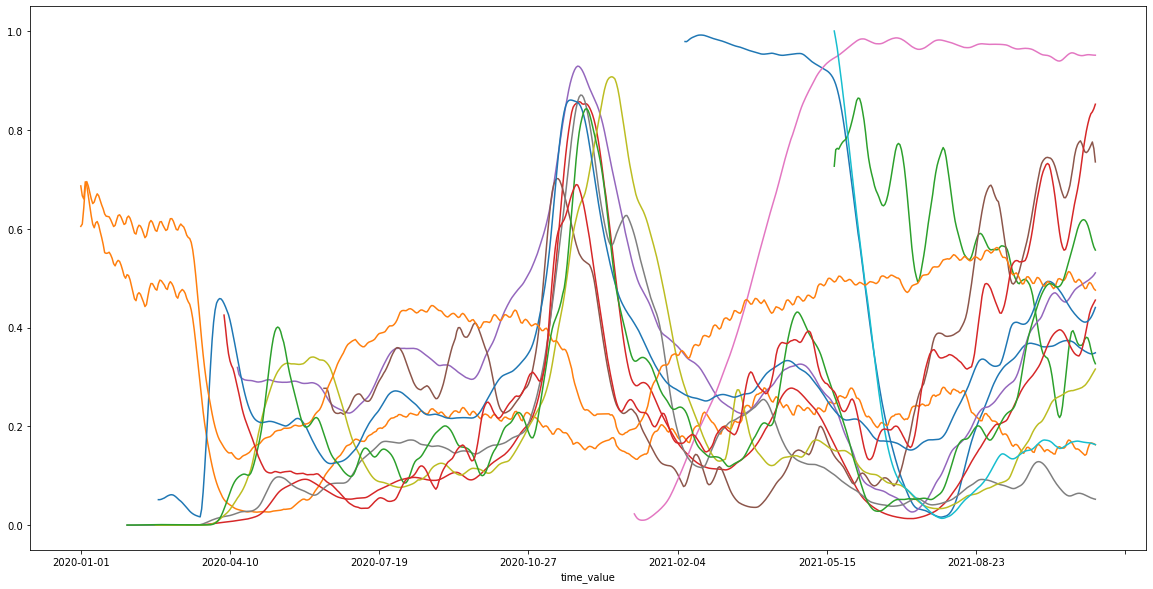

In [74]:
adsmn.plot(legend=False, figsize=(20,10))

<AxesSubplot:xlabel='time_value'>

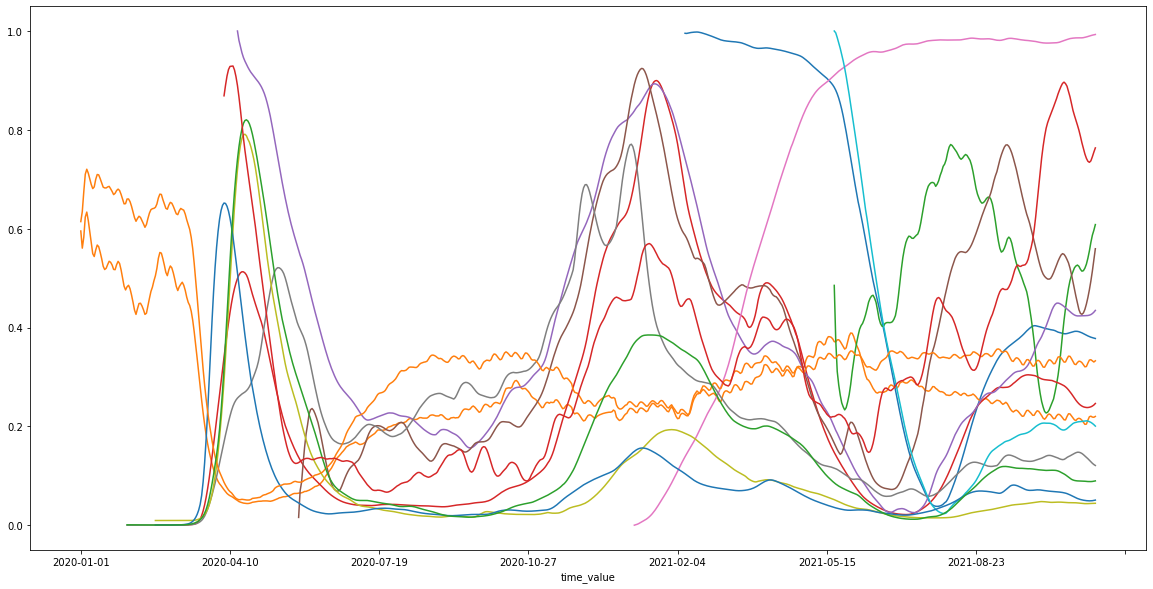

In [77]:
adsny.plot(legend=False, figsize=(20,10))

In [78]:
adsmi.to_csv(f'data/adsmi.csv')
adsmn.to_csv(f'data/adsmn.csv')
adsny.to_csv(f'data/adsny.csv')

In [12]:
adsmi = pd.read_csv(f'data/adsmi.csv')#.set_index('time_value')

In [29]:
recordNums = []
for col in adsmi:
    records = adsmi.index.max() - adsmi[col].first_valid_index()
    print(records, col)
    recordNums += [records]

680 time_value
275 fb-survey_smoothed_wwearing_mask_7d
680 safegraph_bars_visit_prop
175 fb-survey_smoothed_wcovid_vaccinated_appointment_or_accept
630 jhu-csse_confirmed_7dav_incidence_prop
575 fb-survey_smoothed_whh_cmnty_cli
534 quidel_covid_ag_smoothed_pct_positive
309 fb-survey_smoothed_wcovid_vaccinated
649 doctor-visits_smoothed_adj_cli
630 jhu-csse_deaths_7dav_incidence_prop
175 fb-survey_smoothed_wothers_masked_public
630 google-symptoms_sum_anosmia_ageusia_smoothed_search
680 safegraph_restaurants_visit_prop
649 hospital-admissions_smoothed_adj_covid19_from_claims
584 fb-survey_smoothed_wcli


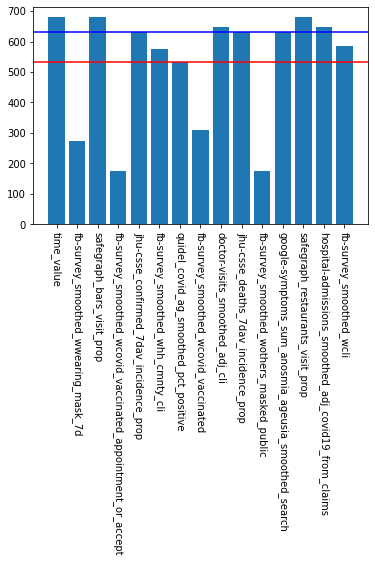

In [34]:
plt.bar(adsmi.columns,recordNums)
plt.xticks(rotation=270)
plt.axhline(y = 630, color = 'b', linestyle = '-')
plt.axhline(y = 534, color = 'r', linestyle = '-')
plt.show()

In [37]:
'blue line', adsmi.loc[adsmi.index.max() - 630]['time_value']

('blue line', '2020-02-20')

In [36]:
'red line', adsmi.loc[adsmi.index.max() - 534]['time_value']

('red line', '2020-05-26')

In [46]:
adsmi.loc[adsmi.index.max() - 630]

time_value                                                    2020-02-20
fb-survey_smoothed_wwearing_mask_7d                                  NaN
safegraph_bars_visit_prop                                       0.433318
fb-survey_smoothed_wcovid_vaccinated_appointment_or_accept           NaN
jhu-csse_confirmed_7dav_incidence_prop                               0.0
fb-survey_smoothed_whh_cmnty_cli                                     NaN
quidel_covid_ag_smoothed_pct_positive                                NaN
fb-survey_smoothed_wcovid_vaccinated                                 NaN
doctor-visits_smoothed_adj_cli                                       0.0
jhu-csse_deaths_7dav_incidence_prop                                  0.0
fb-survey_smoothed_wothers_masked_public                             NaN
google-symptoms_sum_anosmia_ageusia_smoothed_search             0.014444
safegraph_restaurants_visit_prop                                0.624827
hospital-admissions_smoothed_adj_covid19_from_claim

In [48]:
adsmi.index.max() - 630

50

<AxesSubplot:>

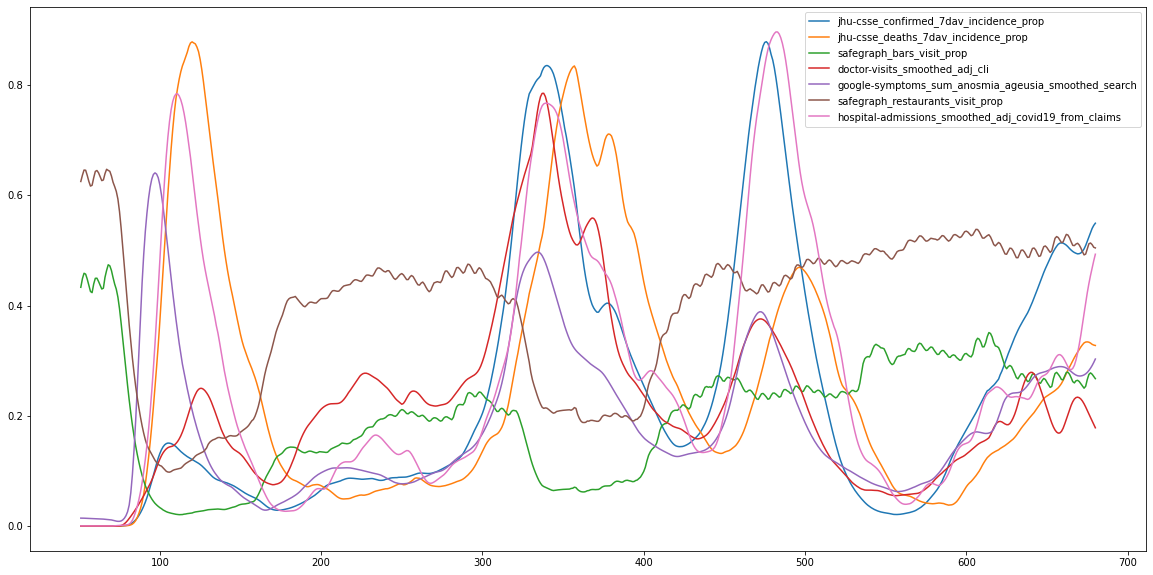

In [54]:
cols = ['jhu-csse_confirmed_7dav_incidence_prop', 'jhu-csse_deaths_7dav_incidence_prop','safegraph_bars_visit_prop', 'doctor-visits_smoothed_adj_cli', 'google-symptoms_sum_anosmia_ageusia_smoothed_search', 'safegraph_restaurants_visit_prop', 'hospital-admissions_smoothed_adj_covid19_from_claims']
tofit = adsmi[adsmi.index > (adsmi.index.max() - 630) ][cols]
tofit.plot(figsize=(20,10))

In [7]:
raw_mi = pd.read_csv(f'data/raw_data_mi.csv')

In [12]:
raw_mi['jhu-csse_confirmed_7dav_incidence_prop'].sum()

12786.1122062

In [15]:
population = 9987000
rate = 9987000 / 100000

In [17]:
raw_mi['total_inc'] = raw_mi['jhu-csse_confirmed_7dav_incidence_prop'] * rate

In [20]:
raw_mi['total_inc'].describe()

count     622.000000
mean     2052.972711
std      2005.605589
min         0.000000
25%       576.787925
50%      1211.909547
75%      3236.590106
max      8117.618070
Name: total_inc, dtype: float64

In [35]:
raw_mi = raw_mi.reset_index()

In [41]:
raw_mi.index

RangeIndex(start=0, stop=681, step=1)

In [52]:
i = 100
raw_mi[(raw_mi['index'] > i - 120) & (raw_mi['index'] <= i)]['jhu-csse_confirmed_7dav_incidence_prop'].sum()

193.6748887

In [34]:
def calc_infectable(row):
    return raw_mi[(raw_mi['index'] > row['index'] - 120) & (raw_mi['index'] <= row['index'])]['jhu-csse_confirmed_7dav_incidence_prop'].sum()

In [60]:
raw_mi['immune'] = raw_mi.apply(lambda x: calc_infectable(x), axis=1)

<AxesSubplot:>

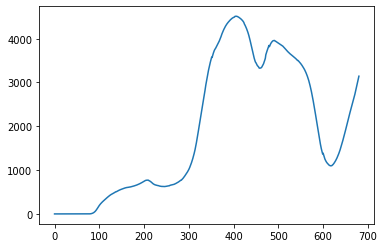

In [61]:
raw_mi['immune'].plot()

In [81]:
def calc_infectable(row, df):
    return df[(df['index'] > row['index'] - 90) & (df['index'] <= row['index'])]['jhu-csse_confirmed_7dav_incidence_prop'].sum()

In [77]:
ads_mi = pd.read_csv(f'data/adsmi.csv')
ads_mn = pd.read_csv(f'data/adsmn.csv')
ads_ny = pd.read_csv(f'data/adsny.csv')

In [79]:
def add_immune(df, name):
    df = df.reset_index()

    df['immune'] = df.apply(lambda x: calc_infectable(x, df), axis=1)

    del df['index']
    df = df.set_index('time_value')
    df = (df-df.min())/(df.max()-df.min())

    print(df.columns)

    df.to_csv(f'data/{name}.csv')

In [80]:
add_immune(ads_ny.copy(), 'adsny')

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [15]:
ads_mi = ads_mi.set_index('time_value')

<AxesSubplot:xlabel='time_value'>

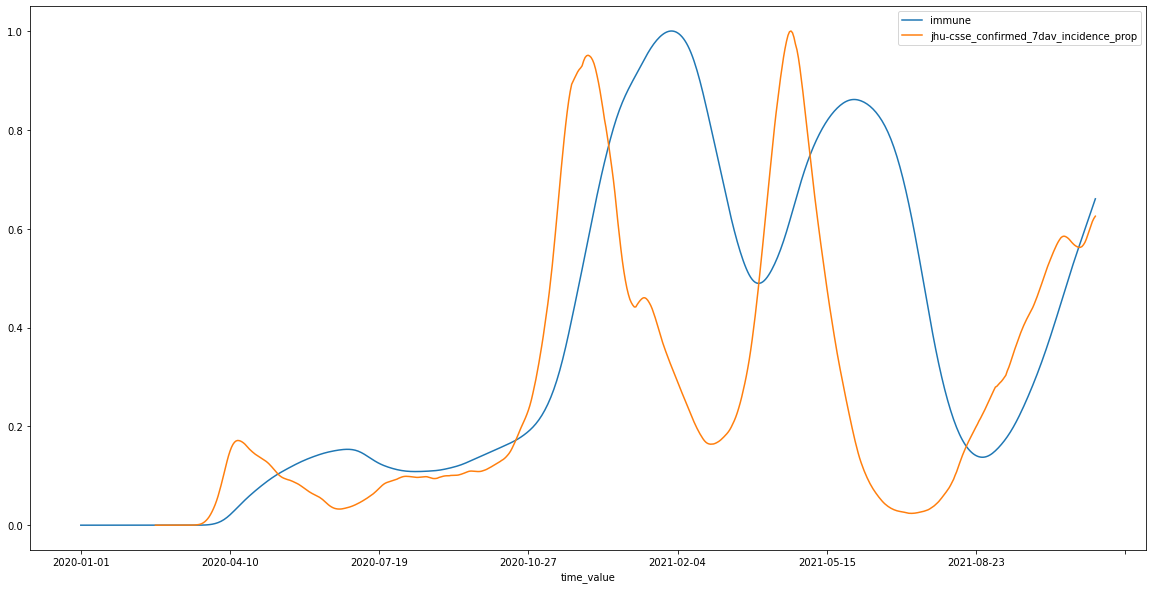

In [16]:
ads_mi[['immune', 'jhu-csse_confirmed_7dav_incidence_prop']].plot(figsize=(20,10))

In [28]:
ads_mi.index.min()

'2020-01-01'

In [29]:
ads_mi.index.max()

'2021-11-11'

In [38]:
ads_mi.columns

Index(['fb-survey_smoothed_wwearing_mask_7d', 'safegraph_bars_visit_prop',
       'fb-survey_smoothed_wcovid_vaccinated_appointment_or_accept',
       'jhu-csse_confirmed_7dav_incidence_prop',
       'fb-survey_smoothed_whh_cmnty_cli',
       'quidel_covid_ag_smoothed_pct_positive',
       'fb-survey_smoothed_wcovid_vaccinated',
       'doctor-visits_smoothed_adj_cli', 'jhu-csse_deaths_7dav_incidence_prop',
       'fb-survey_smoothed_wothers_masked_public',
       'google-symptoms_sum_anosmia_ageusia_smoothed_search',
       'safegraph_restaurants_visit_prop',
       'hospital-admissions_smoothed_adj_covid19_from_claims',
       'fb-survey_smoothed_wcli', 'immune'],
      dtype='object')

array([<AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>,
       <AxesSubplot:xlabel='time_value'>], dtype=object)

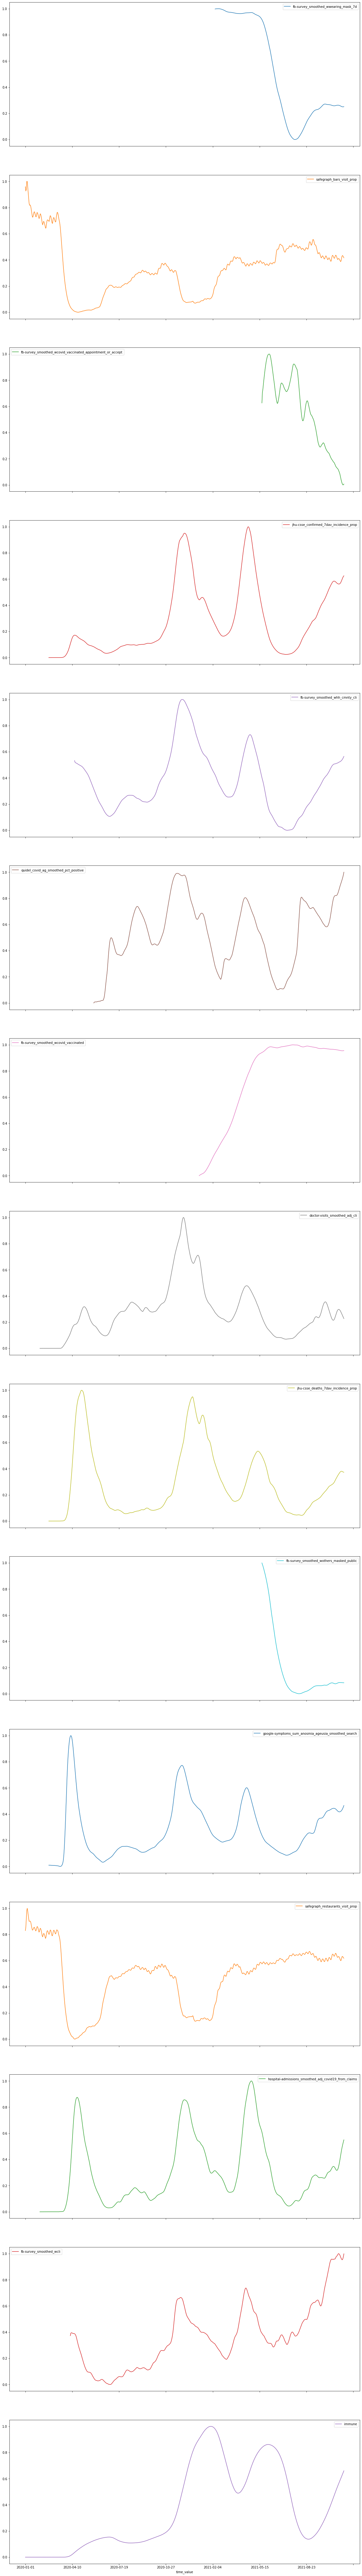

In [37]:
ads_mi.plot(subplots=True, figsize=(20,150), sharex = True, use_index = True)